In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## Basic AE
1. Learning Rate is a very important Hyperparam: usually 0.01 is good
2. Adam or Adadelta are usually good
3. If normalized, use tf.variance_scaling_initializer() for fast convergence

In [3]:
def basic_ae(n_hidden, input_dim, reg=None, reg_param=None):
    """
        Though named basic, this function is able to create undercomplete AE,
        Sparse AE, and AE with dropout
    """
    initializer = tf.variance_scaling_initializer()
    X_ph = tf.placeholder(tf.float32, shape=(None, input_dim))
    W_1 = tf.Variable(initializer([input_dim, n_hidden]), dtype=tf.float32)
    b_1 = tf.Variable(tf.zeros(n_hidden), dtype=tf.float32)
    z_1 = tf.matmul(X_ph, W_1) + b_1
    a_1 = tf.nn.sigmoid(z_1)
    if reg == 'dropout':
        encoded = tf.nn.dropout(a_1, rate=reg_param) # reg_param = 1 - keep_prob here
    else:
        encoded = a_1
    W_2 = tf.Variable(initializer([n_hidden, input_dim]), dtype=tf.float32)
    b_2 = tf.Variable(tf.zeros(input_dim), dtype=tf.float32)
    z_2 = tf.matmul(encoded, W_2) + b_2
    a_2 = tf.nn.sigmoid(z_2)
    if reg == 'dropout':
        decoded = tf.nn.dropout(a_2, rate=reg_param) # reg_param = 1 - keep_prob here
    else:
        decoded = a_2
    
    if reg == 'l1':
        # divide reg_param by two as we ought to take avg of the two tf.reduce_mean
        reg_factor = tf.constant(reg_param/2)
        loss = tf.reduce_mean(tf.square(decoded-X_ph)) +\
                reg_factor*(tf.reduce_mean(tf.abs(W_1)) + tf.reduce_mean(tf.abs(W_2)))
    else:
        loss = tf.reduce_mean(tf.square(decoded-X_ph))
        
    optimizer = tf.train.AdamOptimizer(0.01)
    train_op = optimizer.minimize(loss)
    
    return X_ph, encoded, decoded, loss, train_op

Instructions for updating:
Colocations handled automatically by placer.
1/50 finished, training loss: 0.05817635919898748
2/50 finished, training loss: 0.039284258658687274
3/50 finished, training loss: 0.03295083777979016
4/50 finished, training loss: 0.029888487824549278
5/50 finished, training loss: 0.027097480886926255
6/50 finished, training loss: 0.025605015295247238
7/50 finished, training loss: 0.0243182593708237
8/50 finished, training loss: 0.02303922953704993
9/50 finished, training loss: 0.021605940156926712
10/50 finished, training loss: 0.020018073686709006
11/50 finished, training loss: 0.018496258879701296
12/50 finished, training loss: 0.017319062780588864
13/50 finished, training loss: 0.016509491118292013
14/50 finished, training loss: 0.01543748140335083
15/50 finished, training loss: 0.01451842138543725
16/50 finished, training loss: 0.013802180855224529
17/50 finished, training loss: 0.013186360709369183
18/50 finished, training loss: 0.012703585311149557
19/50 fi

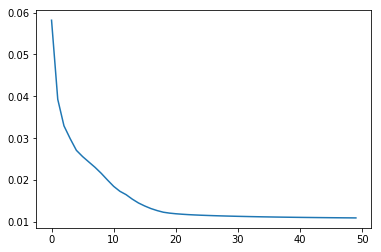

In [4]:
X_ph, encoded, decoded, loss, train_op = basic_ae(32, 784)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
training_loss = []
n_batches = 300 # that will lead to a batch size of 200
batches = np.split(x_train, n_batches)
np.random.shuffle(batches)
n_epoches = 50

for epoch in range(n_epoches):
    batch_loss = 0
    for b in batches:
        _, losses = sess.run([train_op, loss], feed_dict={X_ph: b})
        batch_loss += losses
    training_loss.append(batch_loss/n_batches)
    print(f'{epoch+1}/{n_epoches} finished, training loss: {batch_loss/n_batches}')
plt.plot(training_loss)
plt.show()

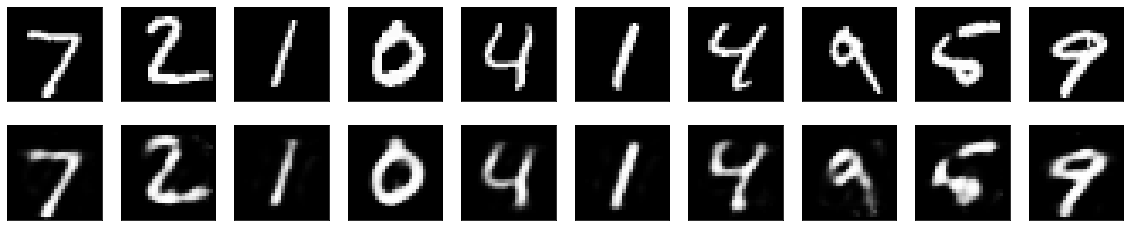

In [5]:
decoded_imgs = sess.run(decoded, feed_dict={X_ph: x_test})
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Adding Sparsity Constraint - L1 Regularization

1/50 finished, training loss: 0.06442052512119213
2/50 finished, training loss: 0.0446036401639382
3/50 finished, training loss: 0.039167736656963825
4/50 finished, training loss: 0.03687601740161578
5/50 finished, training loss: 0.03559751828511556
6/50 finished, training loss: 0.034542005161444345
7/50 finished, training loss: 0.0334269049949944
8/50 finished, training loss: 0.032560565682748954
9/50 finished, training loss: 0.031925422058751186
10/50 finished, training loss: 0.0314775096749266
11/50 finished, training loss: 0.031141437031328677
12/50 finished, training loss: 0.030847648177295923
13/50 finished, training loss: 0.030565645787864925
14/50 finished, training loss: 0.030318308534721533
15/50 finished, training loss: 0.03010609849045674
16/50 finished, training loss: 0.029926989525556565
17/50 finished, training loss: 0.029786736847211916
18/50 finished, training loss: 0.029675902867068848
19/50 finished, training loss: 0.02959012852360805
20/50 finished, training loss: 0

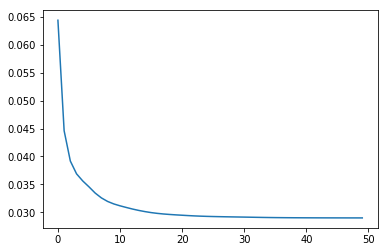

In [6]:
# close the previous tf.Session
sess.close()

X_ph, encoded, decoded, loss, train_op = basic_ae(32, 784, reg='l1', reg_param=0.1)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
n_epoches = 50
training_loss = []
for epoch in range(n_epoches):
    batch_loss = 0
    for b in batches:
        _, losses = sess.run([train_op, loss], feed_dict={X_ph: b})
        batch_loss += losses
    training_loss.append(batch_loss/n_batches)
    print(f'{epoch+1}/{n_epoches} finished, training loss: {batch_loss/n_batches}')
plt.plot(training_loss)
plt.show()

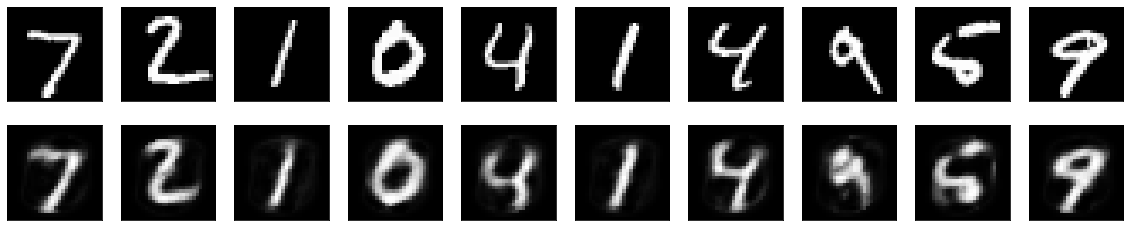

In [7]:
decoded_imgs = sess.run(decoded, feed_dict={X_ph: x_test})
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Dropout Regularization

1/50 finished, training loss: 0.06374682125945887
2/50 finished, training loss: 0.05068139852335056
3/50 finished, training loss: 0.0483234728500247
4/50 finished, training loss: 0.047407346939047176
5/50 finished, training loss: 0.04577032076815764
6/50 finished, training loss: 0.04456516126791636
7/50 finished, training loss: 0.043503158787886305
8/50 finished, training loss: 0.04292549062520266
9/50 finished, training loss: 0.042232645029822984
10/50 finished, training loss: 0.04111508873601755
11/50 finished, training loss: 0.04026308777431647
12/50 finished, training loss: 0.039622019305825235
13/50 finished, training loss: 0.03899455870191256
14/50 finished, training loss: 0.03841214234630267
15/50 finished, training loss: 0.037669543599088987
16/50 finished, training loss: 0.03683965994045138
17/50 finished, training loss: 0.03562093251695236
18/50 finished, training loss: 0.03424418073147535
19/50 finished, training loss: 0.033242411154011886
20/50 finished, training loss: 0.03

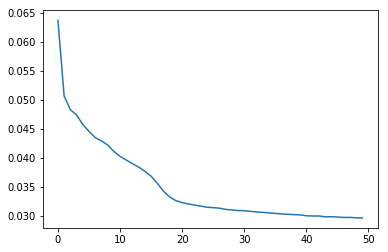

In [8]:
# close the previous tf.Session
sess.close()

X_ph, encoded, decoded, loss, train_op = basic_ae(32, 784, reg='dropout', reg_param=0.1)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
n_epoches = 50
training_loss = []
for epoch in range(n_epoches):
    batch_loss = 0
    for b in batches:
        _, losses = sess.run([train_op, loss], feed_dict={X_ph: b})
        batch_loss += losses
    training_loss.append(batch_loss/n_batches)
    print(f'{epoch+1}/{n_epoches} finished, training loss: {batch_loss/n_batches}')
plt.plot(training_loss)
plt.show()

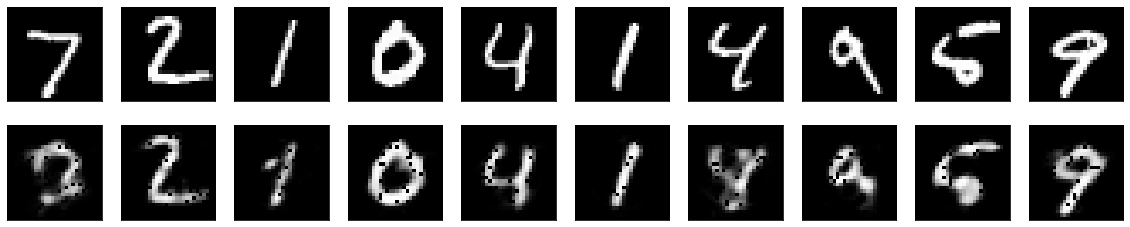

In [9]:
decoded_imgs = sess.run(decoded, feed_dict={X_ph: x_test})
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
sess.close()

## Denoising AE

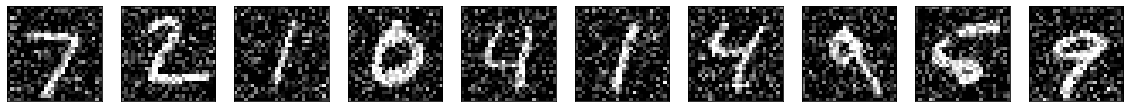

In [10]:
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [15]:
sess.close()
def denoise_ae(n_hidden, input_dim, reg=None, reg_param=0.1):
    initializer = tf.variance_scaling_initializer()
    X_ph = tf.placeholder(tf.float32, shape=(None, input_dim)) # noisy input
    Y_ph = tf.placeholder(tf.float32, shape=(None, input_dim)) # orginal data
    W_1 = tf.Variable(initializer([input_dim, n_hidden]), dtype=tf.float32)
    b_1 = tf.Variable(tf.zeros(n_hidden), dtype=tf.float32)
    z_1 = tf.matmul(X_ph, W_1) + b_1
    a_1 = tf.nn.sigmoid(z_1)
    if reg == 'dropout':
        encoded = tf.nn.dropout(a_1, rate=reg_param) # reg_param = 1 - keep_prob here
    else:
        encoded = a_1
    W_2 = tf.Variable(initializer([n_hidden, input_dim]), dtype=tf.float32)
    b_2 = tf.Variable(tf.zeros(input_dim), dtype=tf.float32)
    z_2 = tf.matmul(encoded, W_2) + b_2
    a_2 = tf.nn.sigmoid(z_2)
    if reg == 'dropout':
        decoded = tf.nn.dropout(a_2, rate=reg_param) # reg_param = 1 - keep_prob here
    else:
        decoded = a_2
    
    
    if reg == 'l1':
        reg_factor = tf.constant(reg_param)
        loss = tf.reduce_mean(tf.square(decoded-Y_ph)) +\
                reg_factor*(tf.reduce_mean(tf.abs(W_1)) + tf.reduce_mean(tf.abs(W_2)))
    else:
        loss = tf.reduce_mean(tf.square(decoded-Y_ph))
    optimizer = tf.train.AdamOptimizer(0.01)
    train_op = optimizer.minimize(loss)
    
    return X_ph, Y_ph, encoded, decoded, loss, train_op

# we enlarge the number of hidden units to 64 as this is more difficult task
X_ph, Y_ph, encoded, decoded, loss, train_op = denoise_ae(64, 784, reg='l1', reg_param=0.1)

1/50 finished, training loss: 0.06023220115651687
2/50 finished, training loss: 0.039214253512521585
3/50 finished, training loss: 0.03390677543977896
4/50 finished, training loss: 0.030874136748413245
5/50 finished, training loss: 0.028771280385553835
6/50 finished, training loss: 0.0271643128618598
7/50 finished, training loss: 0.0260291856341064
8/50 finished, training loss: 0.02527129093185067
9/50 finished, training loss: 0.024790986329317092
10/50 finished, training loss: 0.0244968048731486
11/50 finished, training loss: 0.024324723097185294
12/50 finished, training loss: 0.02420252642904719
13/50 finished, training loss: 0.02410697870577375
14/50 finished, training loss: 0.02402869046355287
15/50 finished, training loss: 0.02396458908294638
16/50 finished, training loss: 0.023907455323884885
17/50 finished, training loss: 0.02385615922510624
18/50 finished, training loss: 0.02381621723373731
19/50 finished, training loss: 0.02378806720798214
20/50 finished, training loss: 0.0237

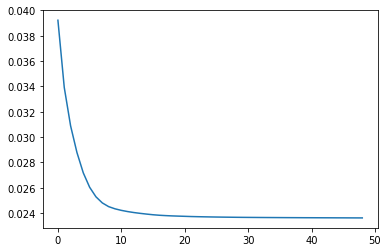

In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
training_loss = []

# we need to shuffle two datasets at the same time, so might as well shuffle the indexing
batch_index = np.split(np.arange(x_train.shape[0]), n_batches)
np.random.shuffle(batch_index)
n_epoches = 50

for epoch in range(n_epoches):
    batch_loss = 0
    for idx in batch_index:
        _, losses = sess.run([train_op, loss], feed_dict={X_ph: x_train_noisy[idx],
                                                            Y_ph: x_train[idx]})
        batch_loss += losses
    training_loss.append(batch_loss/n_batches)
    print(f'{epoch+1}/{n_epoches} finished, training loss: {batch_loss/n_batches}')
plt.plot(training_loss[1:])
plt.show()

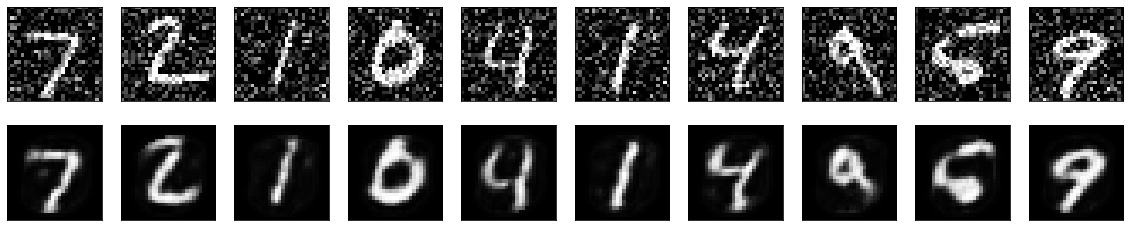

In [13]:
decoded_imgs = sess.run(decoded, feed_dict={X_ph: x_test_noisy})
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
sess.close()

## Contractive AE
> Instead of L-1 or Dropout, CAE uses Frobenius norm of the Jacobian matrix. The purpose is to make the learned representation to be robust towards small changes around the training examples

In [63]:
def contractive_ae(n_hidden, input_dim, reg_param=0.1):
    initializer = tf.variance_scaling_initializer()
    X_ph = tf.placeholder(tf.float32, shape=(None, input_dim))
    W_1 = tf.Variable(initializer([input_dim, n_hidden]), dtype=tf.float32)
    b_1 = tf.Variable(tf.zeros(n_hidden), dtype=tf.float32)
    z_1 = tf.matmul(X_ph, W_1) + b_1
    encoded = tf.nn.sigmoid(z_1)
    W_2 = tf.Variable(initializer([n_hidden, input_dim]), dtype=tf.float32)
    b_2 = tf.Variable(tf.zeros(input_dim), dtype=tf.float32)
    z_2 = tf.matmul(encoded, W_2) + b_2
    decoded = tf.nn.sigmoid(z_2)
    
    # Frobenius norm of the Jacobian
    contractive_loss = tf.reduce_sum(tf.square([tf.gradients(encoded[i], X_ph
                                              ) for i in range(n_hidden)]))

    loss = tf.reduce_mean(tf.square(decoded-X_ph)) + \
            tf.constant(reg_param)*contractive_loss
    optimizer = tf.train.AdamOptimizer(0.01)
    train_op = optimizer.minimize(loss)
    
    return X_ph, encoded, decoded, loss, train_op

In [64]:
sess.close()
X_ph, encoded, decoded, loss, train_op = contractive_ae(32, 784)
sess = tf.Session()
sess.run(tf.global_variables_initializer())
training_loss = []
n_batches = 300 # that will lead to a batch size of 200
batches = np.split(x_train, n_batches)
np.random.shuffle(batches)
n_epoches = 50

for epoch in range(n_epoches):
    batch_loss = 0
    for b in batches:
        _, losses = sess.run([train_op, loss], feed_dict={X_ph: b})
        batch_loss += losses
    training_loss.append(batch_loss/n_batches)
    print(f'{epoch+1}/{n_epoches} finished, training loss: {batch_loss/n_batches}')
plt.plot(training_loss)
plt.show()

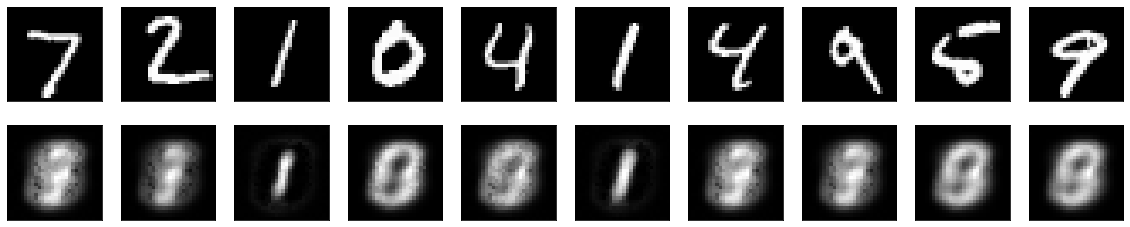

In [66]:
decoded_imgs = sess.run(decoded, feed_dict={X_ph: x_test})
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [62]:
sess.close()

In [ ]:
x = tf.placeholder